In [1]:
from tensorflow.compat.v1 import ConfigProto
import os

from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
from tensorflow import keras
from utilsSegmenter import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint


# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout


creating network model using gpu 1


In [147]:
 class SegmenterDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True):
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Dense(32, activation='relu')
        x = Dropout(0.25)
        x = Activation("relu")(x)
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Dense(32, activation='relu')
        x = Dropout(0.25)
        return x

    def create_model(self):

        inputs = Input(shape=self.inputShape)

        down1 = Conv2D(32, (3, 3),padding='same')(inputs)
        down1 = Activation('relu')(down1)
        down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
        down2 = Conv2D(64, (3, 3), padding='same')(down1_pool)
        down2 = Activation('relu')(down2)
        
        down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
        down3 = Conv2D(128, (2, 2), padding='same')(down2_pool)
        down3 = Activation('relu')(down3)
        
        down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
        down4 = Conv2D(32, (2, 2), padding='same')(down3_pool)
        down4 = Activation('relu')(down4)
        
        up1 = UpSampling2D((2, 2))(down4)
        up1 = concatenate([down3, up1], axis=3)
        up1 = Conv2D(256, (3, 3), padding='same')(up1)
        up1 = Activation('relu')(up1)
        up1 = UpSampling2D((4, 4))(up1)


        up2 = Conv2D(128, (2, 2), padding='same')(up1)
        up2 = Activation('relu')(up2)

        classify = Conv2D(self.num_classes, (1, 1), activation='softmax')(up2)

        model = Model(inputs=inputs, outputs=classify)
        model.summary()
        return model 
      

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**. Do not forget to restart kernels. 

In [148]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = SegmenterDNNModel(num_classes=cfg.NUM_CLASS, batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 128, 128, 32) 896         input_18[0][0]                   
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 128, 128, 32) 0           conv2d_110[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 64, 64, 32)   0           activation_96[0][0]              
___________________________________________________________________________________________

In [155]:
opt = tf.optimizers.Adam(cfg.LEARNING_RATE)
#opt = tf.optimizers.SGD(0.1)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=['accuracy'])

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configSegmenter.py.**

In [156]:
#ratios = [6759447/163594240, 6720849/163594240, 9026441/163594240, 141087503/163594240]
history = model.fit_generator(generator = aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          #class_weight='balanced',
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}_{}".format(cfg.NUM_EPOCHS,cfg.BATCH_SIZE), write_graph=True, write_images=False,
                                 histogram_freq=0)])

338/338 [==============================] - 30s 88ms/step - loss: 0.1402 - accuracy: 0.9407 - val_loss: 0.0492 - val_accuracy: 0.9805


11) We can test the model with the test data

In [157]:
# testing model
test_result = model.evaluate_generator(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_acc = round(test_result[1], 4)
print("Test Loss: ", str(test_loss), "Test Accuracy: ", str(test_acc))

Test Loss:  0.0444 Test Accuracy:  0.9828


12) We can also show sample segmentation results

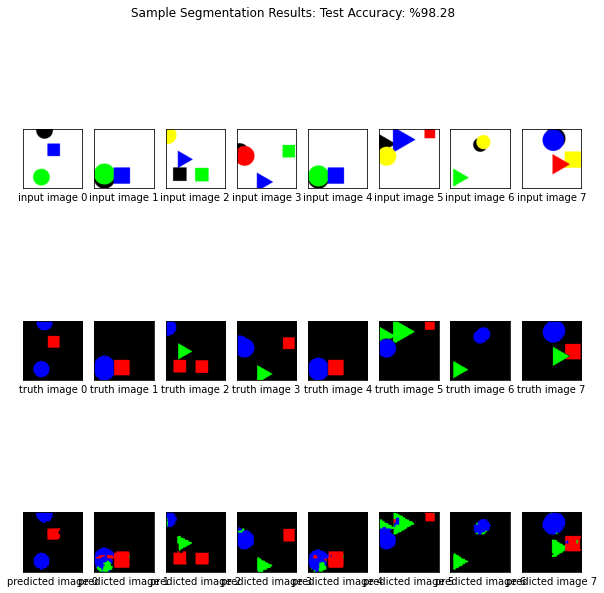

In [158]:
t_data, t_segments = next(test_batch_generator)

pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_segmentation_results(t_data, t_segments, pred_segments, test_acc)

13) Finally, we can save the model

In [159]:
# save the model
model.save('./logs/model_epoch_{}.h5'.format(cfg.NUM_EPOCHS)) 